In [1]:
import os
import imageio
import shutil
import scipy.io
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.image import imread
from scipy.integrate import quad

import solver.conditions as conditions
import solver.utils as utils
import solver.pinn as pinn
import solver.siren as siren
import solver.geometry as geometry
import solver.timedomain as timedomain
import solver.visualizators as visualizators

import warnings
warnings.filterwarnings("ignore")

In [2]:
def initial_condition_function(x):
    return torch.sin(torch.pi * torch.tensor(x))

def boundary_condition_function(x, t):
    return torch.sin(torch.pi * torch.tensor(x) * torch.tensor(t))

def analytical_solution(x, t, alpha, L):
    x = torch.tensor(x)
    t = torch.tensor(t)
    u = torch.zeros_like(x)

    for n in range(1, 100):
        B_n, _ = quad(lambda x: initial_condition_function(x) * np.sin(n * np.pi * x / L), 0, L)
        u += 2 / L * B_n * torch.sin(n * np.pi * x / L) * torch.exp(-alpha**2 * (n * np.pi / L)**2 * t)
    return u

def fdm_solver(problem, Nx, last_only=False):
    L = problem.geom.length()
    T = problem.time.t1
    a = problem.alpha

    dx = L / (Nx - 1)
    dt = dx ** 2 / (4 * a)

    x = torch.linspace(0, 1, Nx)
    Nt = int(T / dt)
    t = torch.linspace(0, 0.5, Nt)

    u = torch.zeros((Nt, Nx))
    u[0, :] = problem.initial_conditions.initial_func(x)

    for n in range(Nt - 1):
        for i in range(1, Nx - 1):
            u[n + 1, i] = u[n, i] + a * dt / dx**2 * (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1])
        u[n + 1, 0] = problem.boundary_conditions.boundary_func(x[0], t[n + 1])
        u[n + 1, -1] = problem.boundary_conditions.boundary_func(x[-1], t[n + 1])

    if last_only:
        return u[-1, :]
    else:
        x, t = torch.meshgrid(x, t)
        u = u.permute(1, 0)
        return x, t, u

In [16]:
geom = geometry.Interval(0.0, 1.0)
period = timedomain.TimeDomain(0.0, 0.5)

initial_conditions = conditions.InitialConditions()
initial_conditions.set_initial_conditions(geom=geom, time=period, 
                                          initial_func=initial_condition_function, 
                                          num_points=1000, random=False, device="cuda:0")
boundary_conditions = conditions.BoundaryConditions()
boundary_conditions.set_boundary_conditions(geom=geom, time=period, 
                                            boundary_func=boundary_condition_function, 
                                            num_points=1000, random=False, device="cuda:0")

equation = conditions.Equation()
equation.set_equation(geom=geom, time=period, num_points=1000, random=False, device="cuda:0")

test = conditions.Test()
test.set_test(geom=geom, time=period, num_points=100, random=False, device="cuda:0")

problem = conditions.Problem(initial_conditions, boundary_conditions, 
                             equation, test, geom, period, alpha=0.1)

# visualizators.conditions_plot(problem, t=0.0)

In [12]:
# x_initial, t_initial, u_initial = problem.initial_conditions.get_initial_conditions()
# x_boundary, t_boundary, u_boundary = problem.boundary_conditions.get_boundary_conditions()

# TODO: Make comparison with analytical solution
# x_equation = torch.linspace(0, 1, 100)
# t_equation = torch.linspace(0, 0.5, 100)
# x_equation, t_equation = torch.meshgrid(x_equation, t_equation)
# u_equation = analytical_solution(x_equation, t_equation, 0.1, 1)

# x_equation, t_equation, u_equation = fdm_solver(problem=problem, Nx=100)
# solution = conditions.Solution()
# solution.set_solution(x_equation, t_equation, u_equation)

# visualizators.solution_surface_plot(problem, solution)

In [13]:
net_params = utils.NetParams()
net_params.set_params(input=2,
                      output=1,
                      hidden_layers=[int(20) for _ in range(2)],
                      epochs=3000,
                      batch_size=100,
                      lr=0.003,
                      activation='tanh',
                      training_mode='train',
                      optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
                      scheduler=None,
                      early_stopping=True,
                      use_rar=False,
                      use_weights_adjuster=False,
                      display_interval=100,
                      model_save_path='models',
                      output_path='out',
                      save_loss=False,
                      initial_weights_path=None,
                      siren_params=None)

# Or load from json file
# net_params.from_json_file("params.json")

In [14]:
model = pinn.PINN(problem, net_params, device='cuda:0')
model.training_mode
model.train()
# TODO: Make LBFGS optimizer work
# TODO: Model approximate incorrect function

Activation Function: Tanh
Hidden Dimensions: 2
Number of neurons: 20
----------
Layer 0: Linear(in_features=2, out_features=20, bias=True) -> Tanh
Layer 1: Linear(in_features=20, out_features=20, bias=True) -> Tanh
Layer 2: Linear(in_features=20, out_features=1, bias=True)
----------
Epoch 2: Loss 465.7546691894531
Epoch 102: Loss 175.7646026611328
Epoch 202: Loss 75.964599609375
Epoch 302: Loss 71.35218048095703
Epoch 402: Loss 69.68125915527344
Epoch 502: Loss 68.25057220458984
Epoch 602: Loss 66.59537506103516
Epoch 702: Loss 64.54341125488281
Epoch 802: Loss 60.126914978027344
Epoch 902: Loss 41.2671012878418
Epoch 1002: Loss 5.562104225158691
Epoch 1102: Loss 2.705214738845825
Epoch 1202: Loss 2.1091904640197754
Epoch 1302: Loss 1.6991840600967407
Epoch 1402: Loss 1.4660401344299316
Epoch 1502: Loss 1.749420166015625
Epoch 1602: Loss 1.1487020254135132
Epoch 1702: Loss 1.0504838228225708
Epoch 1802: Loss 0.9462297558784485
Epoch 1902: Loss 0.8697110414505005
Epoch 2002: Loss 0.799

torch.Size([100])


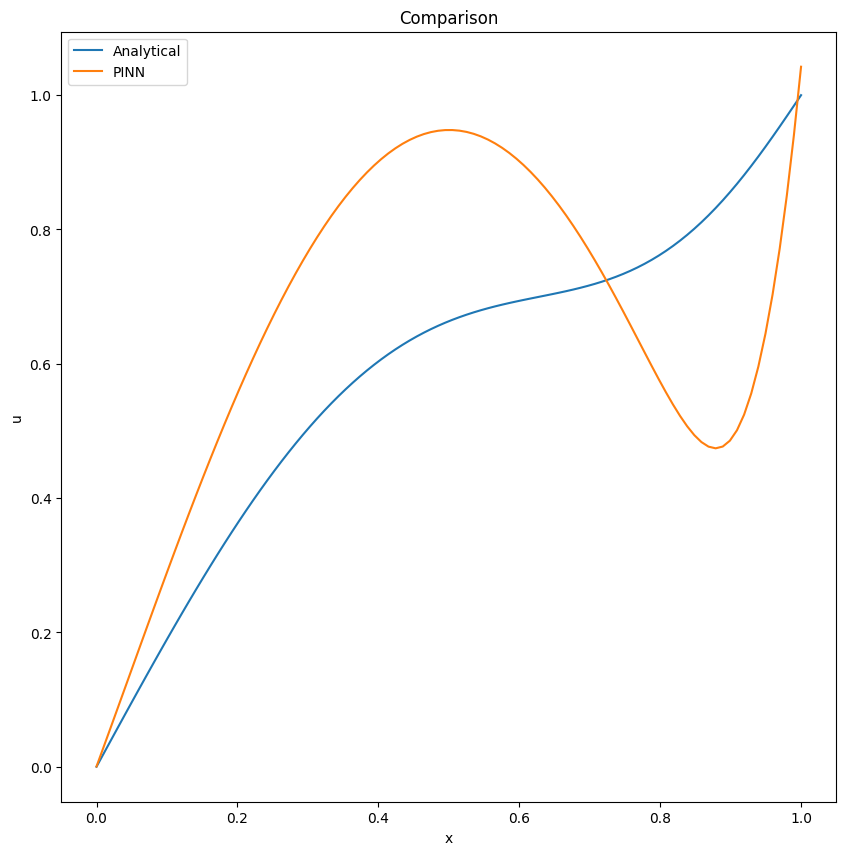

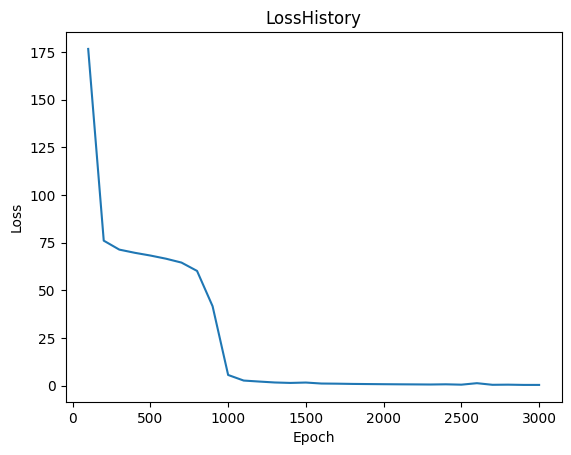

L2 norm: 3.9497551918029785


In [17]:
u_pinn = model.predict(problem.test.x, problem.test.t)
u_analytical = analytical_solution(problem.test.x.cpu().detach().numpy(), 
                                   problem.time.t1, problem.alpha, 
                                   problem.geom.length()).to('cuda:0')
u_fdm = fdm_solver(problem, len(problem.test.x), True)
print(u_fdm.shape)

# Plot of solutions
utils.comparison_plot(problem.test.x, u_fdm, u_pinn, net_params.output_path)
# Plot loss
utils.loss_history_plot(model.get_loss_history(), net_params.output_path)
# L2 norm between analytical and PINN solutions
l2_norm = torch.sqrt(torch.sum((u_analytical - u_pinn)**2) / len(u_analytical))
print(f'L2 norm: {l2_norm}')

### Test of architecture

Siren parameters:  <solver.siren.SirenParams object at 0x00000225A8712150>
Activation Function: str
Hidden Dimensions: 3
Number of neurons: 20
----------
Layer 0: SineLayer(
  (linear): Linear(in_features=2, out_features=20, bias=True)
) -> SineLayer
Layer 1: SineLayer(
  (linear): Linear(in_features=20, out_features=20, bias=True)
) -> SineLayer
Layer 2: SineLayer(
  (linear): Linear(in_features=20, out_features=20, bias=True)
) -> Linear
Layer 3: Linear(in_features=20, out_features=1, bias=True)
----------
L2 norm: 1.4382039079897646


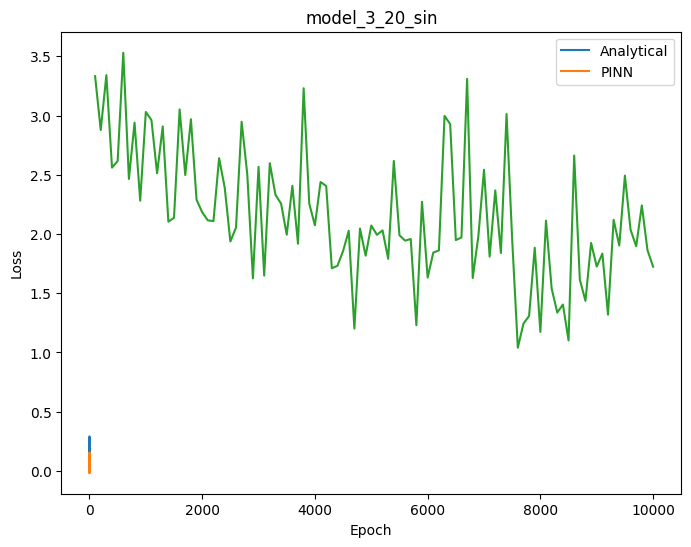

In [ ]:
mesh_params = pinn.MeshParams(size = size,
                              time = time,
                              alpha = alpha,
                              initial_points = initial_points, 
                              boundary_points = boundary_points, 
                              equation_points = equation_points)

siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                 hidden_omega_0 = 30.0,
                                 outermost_linear = True)

net_params = pinn.NetParams(input = 2,
                            output = 1,
                            hidden_layers = [int(20) for _ in range(int(3))],
                            activation = "sin",
                            training_mode = 'full',
                            optimizer = 'Adam',
                            siren_params = siren_params)

model = pinn.PINN(mesh_params, net_params, initial_conditions, boundary_conditions, equation, device='cuda:0')
model.train()

test = conditions.set_test(mesh_params.size, 100, mesh_params.time)
u_pinn = model.predict(test.x, test.t).cpu().detach().numpy()

u_analytical = analytical_solution(test.x.cpu().detach().numpy(), mesh_params.time, alpha, mesh_params.size)

title = f'model_{len(net_params.hidden_layers)}_{net_params.hidden_layers[0]}_{net_params.activation}'
# Plot of solution
make_plot(test.x.cpu().detach().numpy(), u_analytical, u_pinn, model.output_folder, title)
# Plot loss
make_loss_history_plot(model.get_loss_history(), model.output_folder, title)

l2_norm = np.sqrt(np.sum((u_analytical - u_pinn)**2) / len(u_analytical))
print(f'L2 norm: {l2_norm}')

# torch.save(model.net.state_dict(), 
#             os.path.join(weights_dir, f'model_{hidden_layer}_{activation}_{neurons}.pt'))

In [ ]:
output_folder = 'train_img'
os.listdir(output_folder)
images = [imageio.imread(os.path.join(output_folder, f"{image}")) for image in os.listdir(output_folder) if image.endswith(".png")]
imageio.mimsave(os.path.join(os.getcwd(), 'animation.gif'), images, fps=5, duration=0.1, loop=0)

C:\Users\dsash\AppData\Local\Temp\ipykernel_7436\1830411550.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(output_folder, f"{image}")) for image in os.listdir(output_folder) if image.endswith(".png")]


In [ ]:
pinn = pinn.PINN(initial_conditions, boundary_conditions, equation, alpha=0.5)
pinn.net.load_state_dict(torch.load('model.pt'))
pinn.net.eval()

test = conditions.set_test(size, 100, time)

x_test = torch.tensor(test.x[:, np.newaxis], dtype=torch.float32, requires_grad=True)
t_test = torch.tensor(test.t[:, np.newaxis], dtype=torch.float32, requires_grad=True)

u_pinn = pinn.function(x_test, t_test)

### Analytical solution for 2D

In [ ]:
def analytical_solution(x, y):
    l_x = 1.0
    l_y = 1.0
    u_1 = 1.0
    u_2 = 5.0
    lambda_n = [n * np.pi / l_x for n in range(1, 52)]
    return (u_1 + (u_2 - u_1) * (x / l_x)
    + 2.0*(u_2 - u_1) * np.sum(1.0 / (n * np.pi * np.sinh(np.sqrt(lambda_n[n]) * l_y)) * (np.sinh(np.sqrt(lambda_n[n]) * y) + pow(-1, n) * np.sinh(np.sqrt(lambda_n[n]) * (l_y - y))) * np.sin(n * np.pi * x / l_x) for n in range(1, 50)))

### Analytical solution for 1D and comparison with FDM

In [ ]:
def initial_condition(x):
    return np.sin(np.pi * x)

def analytical_solution(x, t, alpha, L):
    sum_terms = 0
    for n in range(1, 100):
        B_n, _ = quad(lambda x: initial_condition(x) * np.sin(n * np.pi * x / L), 0, L)
        sum_terms += 2 / L * B_n * np.sin(n * np.pi * x / L) * np.exp(-alpha**2 * (n * np.pi / L)**2 * t)
    return sum_terms

In [ ]:
def fdm_solver(L, T, num_points, alpha):
    dx = L / (num_points - 1)
    dt = 0.1 * dx**2 / alpha
    r = alpha * dt 

    x_values = np.linspace(0, L, num_points)
    u_values = np.zeros((num_points, int(T / dt) + 1))

    u_values[:, 0] = initial_condition(x_values)

    # Time-stepping with explicit finite difference scheme
    for n in range(1, int(T / dt) + 1):
        for i in range(1, num_points - 1):
            u_values[i, n] = (u_values[i, n - 1] + alpha**2 * dt *
                              (u_values[i + 1, n - 1] - 2 * u_values[i, n - 1] + u_values[i - 1, n - 1]) / dx**2)

    return x_values, u_values

In [ ]:
def comparison_plot(x_values, u_fdm, u_analytical, u_pinn):
    plt.figure(figsize=(8, 6))
    plt.xlabel('x')
    plt.ylabel('temperature')

    plt.plot(x_values, u_fdm, label='FDM')
    plt.plot(x_values, u_analytical, label='Analytical')
    plt.plot(x_values, u_pinn, label='PINN')
    plt.legend()
    plt.show()

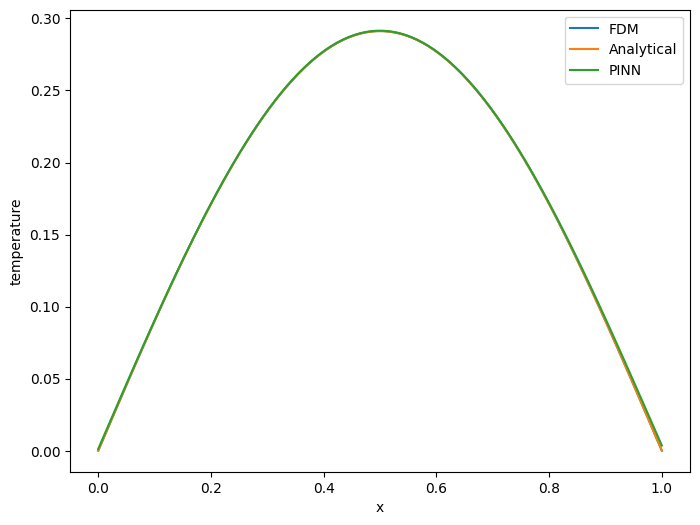

In [ ]:
# Parameters
L = 1.0  # Length
T = 0.5  # Total simulation time
num_points = 100  # Number of spatial grid points
alpha = 0.5  # Thermal diffusivity

# Solve heat equation numerically
x, u_fdm = fdm_solver(L, T, num_points, alpha)
u_fdm = u_fdm[:, -1]

u_analytical = analytical_solution(x, T, alpha, L)

test = conditions.set_test(L, 100, T)
x_test = torch.tensor(test.x[:, np.newaxis], dtype=torch.float32, requires_grad=True)
t_test = torch.tensor(test.t[:, np.newaxis], dtype=torch.float32, requires_grad=True)

u_pinn = pinn.predict(x_test, t_test).detach().numpy()

# Plot numerical vs analytical solution
comparison_plot(x, u_fdm, u_analytical, u_pinn)

In [ ]:
def l2_norm(u1, u2):
    return np.sqrt(np.sum((u1 - u2)**2) / len(u1))

l2_norm_fdm = l2_norm(u_fdm, u_analytical)
l2_norm_pinn = l2_norm(u_pinn, u_analytical)

print(f"L2 norm (FDM vs Analytical): {l2_norm_fdm}")
print(f"L2 norm (PINN vs Analytical): {l2_norm_pinn}")

L2 norm (FDM vs Analytical): 2.0006872687507824e-05
L2 norm (PINN vs Analytical): 1.2844777324290277
